# Model Comparison: Logistic Regression vs MLP vs CNN

This notebook extracts and compares results from three models:
- Logistic Regression (sklearn)
- MLP (PyTorch)
- CNN (PyTorch)

All models use the `laplacian_stft` preprocessor.


In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from glob import glob

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)


In [2]:
def load_results_from_json(file_path, model_name):
    """Load fold-level results from a JSON file."""
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    results = []
    eval_results = data.get("evaluation_results", {})
    
    for subject_key, subject_data in eval_results.items():
        if subject_key.startswith("btbank"):
            parts = subject_key.replace("btbank", "").split("_")
            if len(parts) == 2:
                subject_id = int(parts[0])
                trial_id = int(parts[1])
            else:
                continue
        else:
            continue
            
        population_results = subject_data.get("population", {})
        
        # Extract eval_name from config
        eval_name = "_".join(file_path.split(".")[0].split("/")[-1].split("_")[3:])
        
        # Check if we have folds directly or nested in one_second_after_onset
        if "one_second_after_onset" in population_results:
            one_second = population_results["one_second_after_onset"]
            folds = one_second.get("folds", [])
            for fold_idx, fold_result in enumerate(folds):
                results.append({
                    "model_name": model_name,
                    "eval_name": eval_name,
                    "subject_id": subject_id,
                    "trial_id": trial_id,
                    "fold_idx": fold_result.get("fold_idx", fold_idx),
                    "train_accuracy": fold_result.get("train_accuracy", np.nan),
                    "train_roc_auc": fold_result.get("train_roc_auc", np.nan),
                    "test_accuracy": fold_result.get("test_accuracy", np.nan),
                    "test_roc_auc": fold_result.get("test_roc_auc", np.nan),
                })
    
    return results


def load_all_results_for_model(base_dir, model_name):
    """Load all JSON files for a given model."""
    pattern = f"{base_dir}/eval_results/**/*.json"
    json_files = glob(pattern, recursive=True)
    
    all_results = []
    for json_file in json_files:
        try:
            results = load_results_from_json(json_file, model_name)
            all_results.extend(results)
        except Exception as e:
            print(f"Error loading {json_file}: {e}")
    
    return pd.DataFrame(all_results)


In [3]:
# Define base directories
base_dir = Path("outputs")

# Load results for each model
print("Loading Logistic Regression results...")
df_logistic = load_all_results_for_model(base_dir / "run_all_logistic", "Logistic Regression")
print(f"  Loaded {len(df_logistic)} folds")

print("\nLoading MLP results...")
df_mlp = load_all_results_for_model(base_dir / "run_all_mlp", "MLP")
print(f"  Loaded {len(df_mlp)} folds")

print("\nLoading CNN results...")
df_cnn = load_all_results_for_model(base_dir / "run_all_cnn", "CNN")
print(f"  Loaded {len(df_cnn)} folds")


Loading Logistic Regression results...
  Loaded 96 folds

Loading MLP results...
  Loaded 96 folds

Loading CNN results...
  Loaded 96 folds


In [4]:
# Display summary of each dataframe
print("\n=== Logistic Regression ===")
print(df_logistic.head())
print(f"\nShape: {df_logistic.shape}")
print(f"\nTasks: {df_logistic['eval_name'].unique()}")

print("\n=== MLP ===")
print(df_mlp.head())
print(f"\nShape: {df_mlp.shape}")
print(f"\nTasks: {df_mlp['eval_name'].unique()}")

print("\n=== CNN ===")
print(df_cnn.head())
print(f"\nShape: {df_cnn.shape}")
print(f"\nTasks: {df_cnn['eval_name'].unique()}")



=== Logistic Regression ===
            model_name eval_name  subject_id  trial_id  fold_idx  \
0  Logistic Regression    volume           7         1         0   
1  Logistic Regression    volume           7         1         1   
2  Logistic Regression     onset           4         0         0   
3  Logistic Regression     onset           4         0         1   
4  Logistic Regression     onset           7         0         0   

   train_accuracy  train_roc_auc  test_accuracy  test_roc_auc  
0             1.0            1.0       0.611429      0.638448  
1             1.0            1.0       0.564571      0.605955  
2             1.0            1.0       0.469697      0.756905  
3             1.0            1.0       0.799242      0.897543  
4             1.0            1.0       0.754286      0.822059  

Shape: (96, 9)

Tasks: ['volume' 'onset' 'speech' 'delta_volume']

=== MLP ===
  model_name     eval_name  subject_id  trial_id  fold_idx  train_accuracy  \
0        MLP        

In [5]:
# Concatenate all dataframes
df_all = pd.concat([df_logistic, df_mlp, df_cnn], ignore_index=True)

print(f"Total folds: {len(df_all)}")
print(f"\nModels: {df_all['model_name'].unique()}")
print(f"\nTasks: {df_all['eval_name'].unique()}")
print(f"\nShape: {df_all.shape}")

# Display first few rows
df_all.head(10)


Total folds: 288

Models: ['Logistic Regression' 'MLP' 'CNN']

Tasks: ['volume' 'onset' 'speech' 'delta_volume']

Shape: (288, 9)


,model_name,eval_name,subject_id,trial_id,fold_idx,train_accuracy,train_roc_auc,test_accuracy,test_roc_auc
0,Logistic Regression,volume,7,1,0,1.0,1.0,0.611429,0.638448
1,Logistic Regression,volume,7,1,1,1.0,1.0,0.564571,0.605955
2,Logistic Regression,onset,4,0,0,1.0,1.0,0.469697,0.756905
3,Logistic Regression,onset,4,0,1,1.0,1.0,0.799242,0.897543
4,Logistic Regression,onset,7,0,0,1.0,1.0,0.754286,0.822059
5,Logistic Regression,onset,7,0,1,1.0,1.0,0.793143,0.893305
6,Logistic Regression,onset,2,0,0,1.0,1.0,0.899696,0.947867
7,Logistic Regression,onset,2,0,1,1.0,1.0,0.882979,0.934895
8,Logistic Regression,speech,4,1,0,1.0,1.0,0.777143,0.853883
9,Logistic Regression,speech,4,1,1,1.0,1.0,0.749714,0.827396


## Summary Statistics


In [6]:
# Summary statistics by model and task
summary = df_all.groupby(['model_name', 'eval_name']).agg({
    'test_accuracy': ['mean', 'std', 'count'],
    'test_roc_auc': ['mean', 'std'],
    'train_accuracy': ['mean', 'std'],
    'train_roc_auc': ['mean', 'std']
}).round(4)

print("Summary Statistics by Model and Task:")
summary


Summary Statistics by Model and Task:


test_accuracy               test_roc_auc  \
                                          mean     std count         mean   
model_name          eval_name                                               
CNN                 delta_volume        0.6934  0.0838    24       0.7644   
                    onset               0.8177  0.0898    24       0.9076   
                    speech              0.8226  0.0920    24       0.9058   
                    volume              0.6771  0.1024    24       0.7533   
Logistic Regression delta_volume        0.6949  0.0780    24       0.7572   
                    onset               0.8123  0.1047    24       0.8920   
                    speech              0.8105  0.1008    24       0.8854   
                    volume              0.6506  0.1161    24       0.7234   
MLP                 delta_volume        0.6900  0.0782    24       0.7524   
                    onset               0.8060  0.1116    24       0.8886   
                    speech              0.8023  0.1108    24       0.8797   
                    volume              0.6607  0.1048    24       0.7244   

                                         train_accuracy         train_roc_auc  \
                                     std           mean     std          mean   
model_name          eval_name                                                   
CNN                 delta_volume  0.0968         0.8733  0.0605        0.9481   
                    onset         0.0473         0.9494  0.0499        0.9803   
                    speech        0.0549         0.9369  0.0584        0.9746   
                    volume        0.1298         0.8880  0.1069        0.9501   
Logistic Regression delta_volume  0.0991         1.0000  0.0000        1.0000   
                    onset         0.0717         1.0000  0.0000        1.0000   
                    speech        0.0732         1.0000  0.0000        1.0000   
                    volume        0.1103         1.0000  0.0000        1.0000   
MLP                 delta_volume  0.0979         1.0000  0.0000        1.0000   
                    onset         0.0825         0.9973  0.0134        0.9992   
                    speech        0.0878         0.9971  0.0143        0.9991   
                    volume        0.1105         0.9999  0.0006        1.0000   

                                          
                                     std  
model_name          eval_name             
CNN                 delta_volume  0.0367  
                    onset         0.0279  
                    speech        0.0336  
                    volume        0.0803  
Logistic Regression delta_volume  0.0000  
                    onset         0.0000  
                    speech        0.0000  
                    volume        0.0000  
MLP                 delta_volume  0.0000  
                    onset         0.0038  
                    speech        0.0043  
                    volume        0.0000

In [7]:
# Overall summary by model
overall_summary = df_all.groupby('model_name').agg({
    'test_accuracy': ['mean', 'std', 'min', 'max'],
    'test_roc_auc': ['mean', 'std', 'min', 'max'],
    'train_accuracy': ['mean', 'std'],
    'train_roc_auc': ['mean', 'std']
}).round(4)

print("Overall Summary by Model:")
overall_summary


Overall Summary by Model:


test_accuracy                         test_roc_auc  \
                             mean     std     min     max         mean   
model_name                                                               
CNN                        0.7527  0.1135  0.4754  0.9314       0.8328   
Logistic Regression        0.7421  0.1223  0.3909  0.9280       0.8145   
MLP                        0.7397  0.1201  0.4091  0.9406       0.8113   

                                            train_accuracy          \
                        std     min     max           mean     std   
model_name                                                           
CNN                  0.1147  0.4264  0.9785         0.9119  0.0782   
Logistic Regression  0.1165  0.5015  0.9832         1.0000  0.0000   
MLP                  0.1194  0.5061  0.9867         0.9986  0.0098   

                    train_roc_auc          
                             mean     std  
model_name                                 
CNN                        0.9633  0.0506  
Logistic Regression        1.0000  0.0000  
MLP                        0.9996  0.0028

## Visualizations


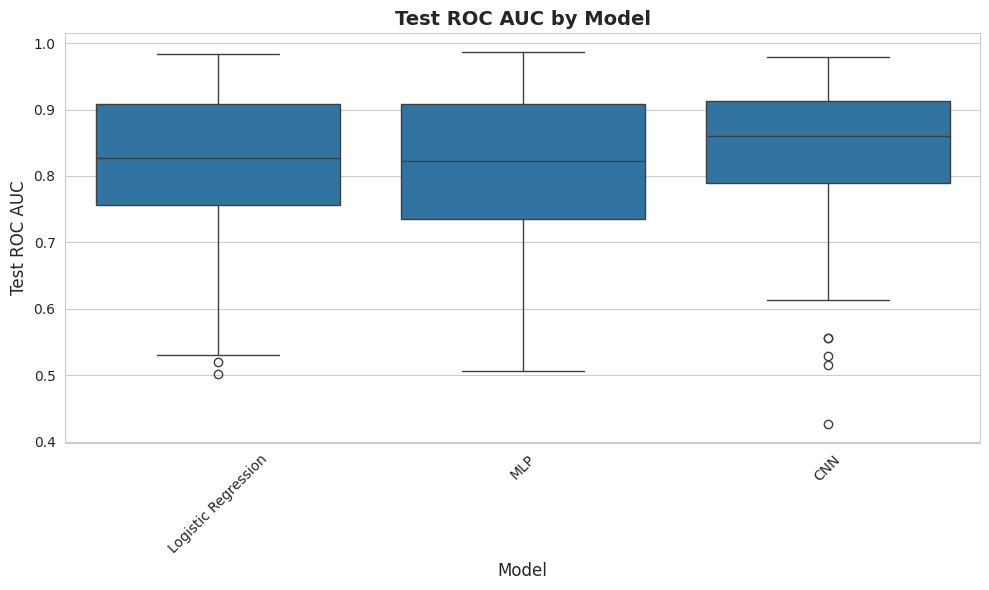

In [8]:
# Box plot: Test ROC AUC by Model
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_all, x='model_name', y='test_roc_auc')
plt.title('Test ROC AUC by Model', fontsize=14, fontweight='bold')
plt.xlabel('Model', fontsize=12)
plt.ylabel('Test ROC AUC', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


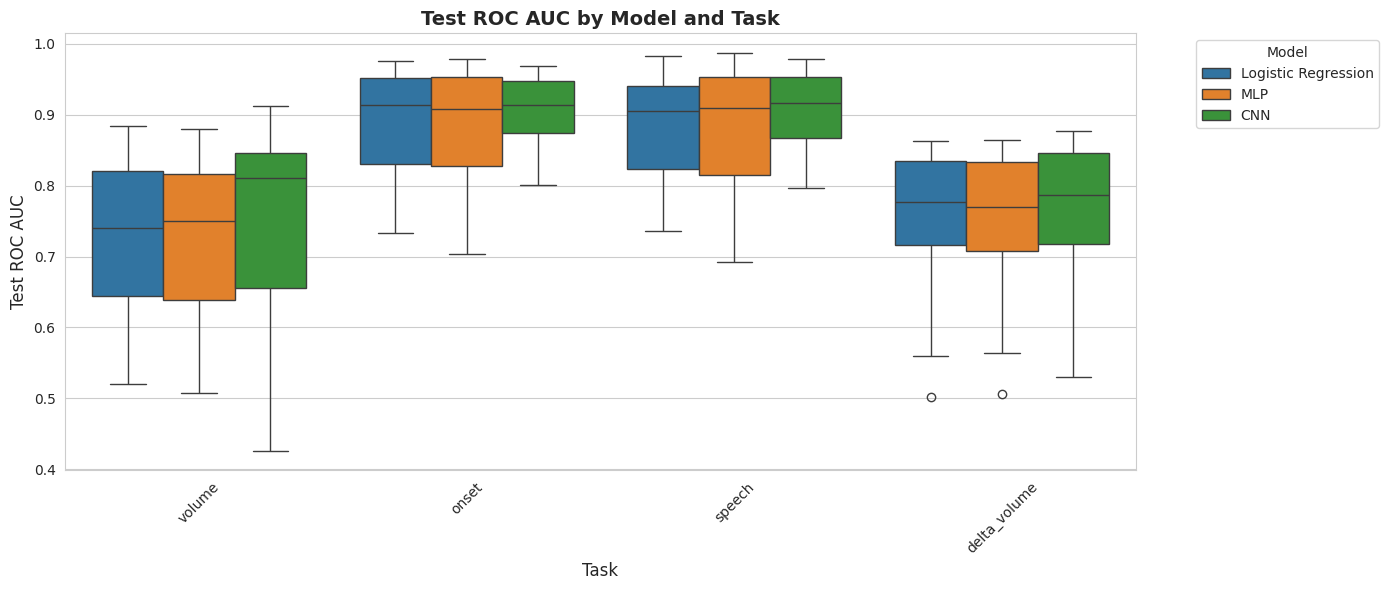

In [12]:
# Box plot: Test ROC AUC by Model and Task
plt.figure(figsize=(14, 6))
sns.boxplot(data=df_all, x='eval_name', y='test_roc_auc', hue='model_name')
plt.title('Test ROC AUC by Model and Task', fontsize=14, fontweight='bold')
plt.xlabel('Task', fontsize=12)
plt.ylabel('Test ROC AUC', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


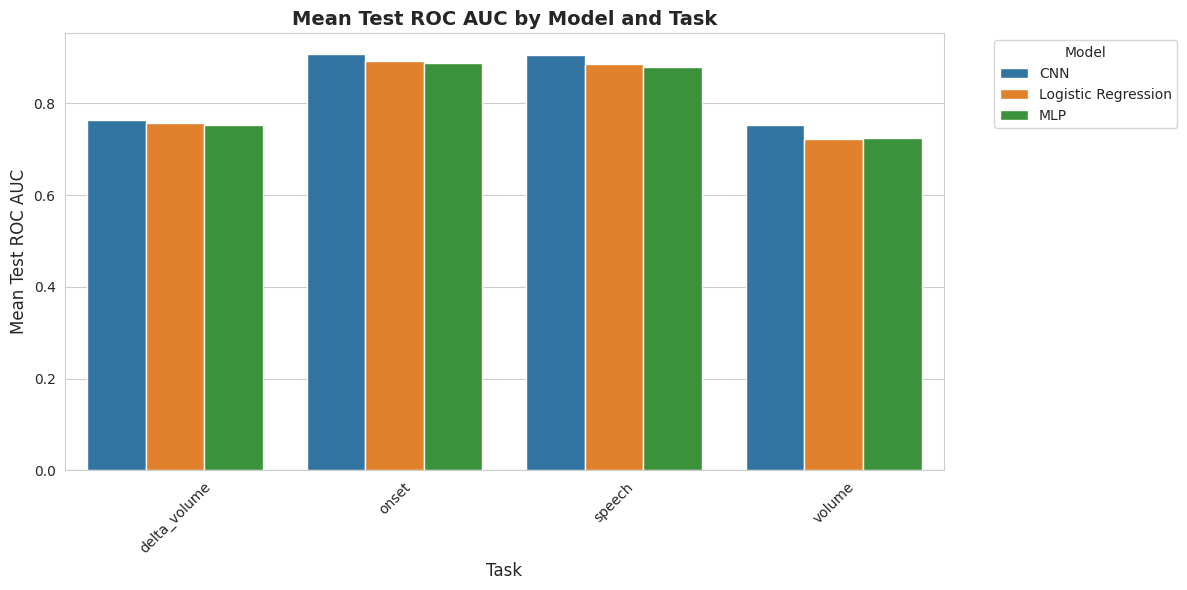

In [11]:
# Bar plot: Mean Test ROC AUC by Model and Task
mean_auc = df_all.groupby(['model_name', 'eval_name'])['test_roc_auc'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(data=mean_auc, x='eval_name', y='test_roc_auc', hue='model_name')
plt.title('Mean Test ROC AUC by Model and Task', fontsize=14, fontweight='bold')
plt.xlabel('Task', fontsize=12)
plt.ylabel('Mean Test ROC AUC', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


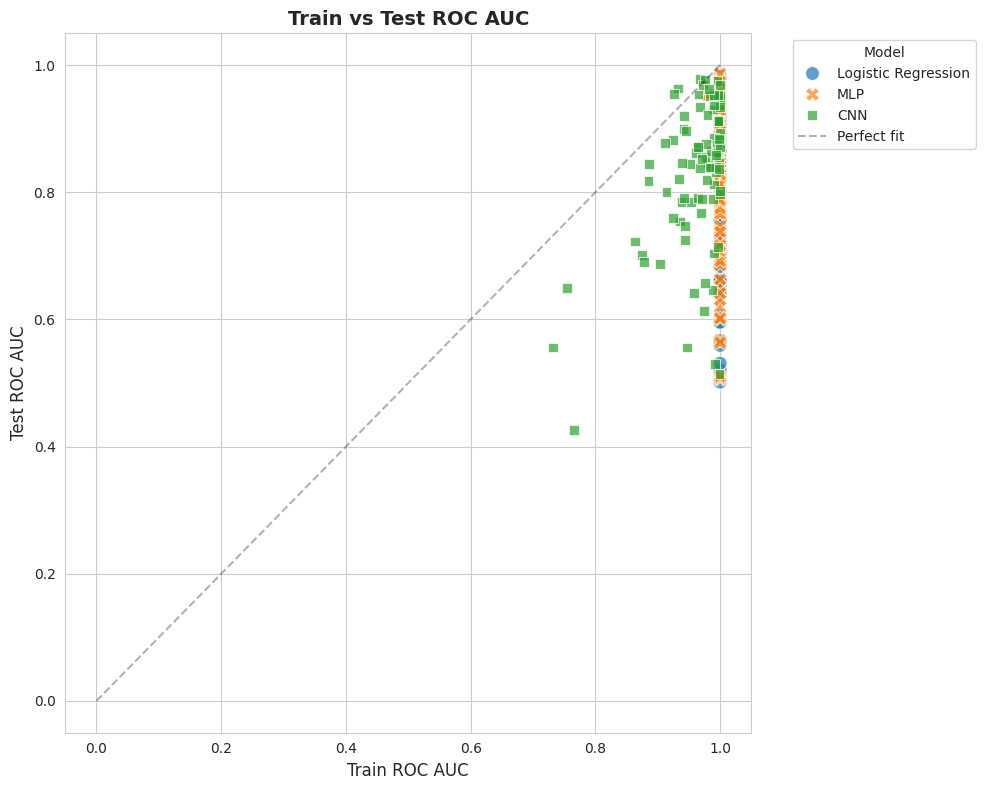

In [14]:
# Scatter plot: Train vs Test ROC AUC
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_all, x='train_roc_auc', y='test_roc_auc', 
                hue='model_name', style='model_name', s=100, alpha=0.7)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='Perfect fit')
plt.title('Train vs Test ROC AUC', fontsize=14, fontweight='bold')
plt.xlabel('Train ROC AUC', fontsize=12)
plt.ylabel('Test ROC AUC', fontsize=12)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Statistical Comparisons


In [16]:
# Compare models pairwise for each task
from scipy import stats

tasks = df_all['eval_name'].unique()
models = df_all['model_name'].unique()

comparisons = []
for task in tasks:
    task_data = df_all[df_all['eval_name'] == task]
    
    for i, model1 in enumerate(models):
        for model2 in models[i+1:]:
            model1_data = task_data[task_data['model_name'] == model1]['test_roc_auc']
            model2_data = task_data[task_data['model_name'] == model2]['test_roc_auc']
            
            if len(model1_data) > 0 and len(model2_data) > 0:
                # Perform t-test
                t_stat, p_value = stats.ttest_ind(model1_data, model2_data)
                
                comparisons.append({
                    'task': task,
                    'model1': model1,
                    'model2': model2,
                    'mean1': model1_data.mean(),
                    'mean2': model2_data.mean(),
                    'diff': model1_data.mean() - model2_data.mean(),
                    't_stat': t_stat,
                    'p_value': p_value,
                    'significant': p_value < 0.05
                })

comparisons_df = pd.DataFrame(comparisons)
print("Pairwise Model Comparisons (t-test):")
comparisons_df.round(4)


Pairwise Model Comparisons (t-test):


,task,model1,model2,mean1,mean2,diff,t_stat,p_value,significant
0,volume,Logistic Regression,MLP,0.7234,0.7244,-0.0010,-0.0329,0.9739,False
1,volume,Logistic Regression,CNN,0.7234,0.7533,-0.0299,-0.8597,0.3944,False
2,volume,MLP,CNN,0.7244,0.7533,-0.0288,-0.8289,0.4114,False
3,onset,Logistic Regression,MLP,0.8920,0.8886,0.0034,0.1520,0.8799,False
4,onset,Logistic Regression,CNN,0.8920,0.9076,-0.0155,-0.8864,0.3800,False
5,onset,MLP,CNN,0.8886,0.9076,-0.0189,-0.9756,0.3344,False
6,speech,Logistic Regression,MLP,0.8854,0.8797,0.0057,0.2446,0.8078,False
7,speech,Logistic Regression,CNN,0.8854,0.9058,-0.0204,-1.0921,0.2805,False
8,speech,MLP,CNN,0.8797,0.9058,-0.0261,-1.2353,0.2230,False
9,delta_volume,Logistic Regression,MLP,0.7572,0.7524,0.0048,0.1702,0.8656,False


In [ ]:
# Save concatenated dataframe
df_all.to_csv('model_comparison_results.csv', index=False)
print("Saved results to 'model_comparison_results.csv'")

# Save summary statistics
summary.to_csv('model_comparison_summary.csv')
print("Saved summary to 'model_comparison_summary.csv'")
